# Benchmarking of various implementations of FADDEEVA's error functions

## I. Setup

Import the multiprecision library `mpmath` as a reference for accuracy benchmarks:

In [1]:
import mpmath

Import the rest of the usual lot:

In [2]:
import numpy as np
import scipy
import ctypes
import sys
import time
%load_ext Cython

a timer class for a more convenient timing

In [3]:
class Timer(object):
    '''Uses time.time() bc timer.clock() doesn't work with GPU/...'''
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval_s = self.end - self.start

The dictionary `wofz_impl` accesses the various function implementations.

Input interface is `wofz_impl[<implementation-folder>](x, y)`: 
`x` is the real and `y` is the imaginary part of the input, both should be numpy arrays (i.e. provide the ctypes field).

In [4]:
wofz_impl = dict()

For argument types needing double pointers, use the ctypes pointer provided by NumPy:

In [5]:
from numpy.ctypeslib import ndpointer
np_double_p = ndpointer(dtype=np.float64)

`ctypes` libraries are loaded into the dictionary `dlls`:

In [6]:
dlls = dict()

### mpmath (reference)

set the precision:

In [7]:
mpmath.mp.dps = 50

prepare the `wofz_impl` entry:

In [8]:
def wofz(x, y):
    z = mpmath.mpc(x, y)
    w = mpmath.exp(-z**2) * mpmath.erfc(z * -1j)
    return w.real, w.imag
wofz_impl['mp'] = np.vectorize(wofz)

### scipy (version > 0.14)

http://ab-initio.mit.edu/wiki/index.php/Faddeeva_Package

In [9]:
from scipy.special import wofz as scipy_wofz

prepare the `wofz_impl` entry:

In [10]:
def wofz(x, y):
    z = scipy_wofz(x + 1j*y)
    return z.real, z.imag
wofz_impl['scipy'] = wofz

### cernlib-c


loading the external shared C library:

In [11]:
dlls['c'] = ctypes.cdll.LoadLibrary('cernlib-c/wofz.so')
dlls['c'].cerrf.restype = None
dlls['c'].cerrf.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

prepare the `wofz_impl` entry:

In [12]:
def wofz(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c'].cerrf(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c'] = np.vectorize(wofz)

### cernlib-cuda-1

try whether PyCUDA is available for the CUDA FADDEEVA version:

In [13]:
i_pycuda = False
try:
    from pycuda.autoinit import context
    from pycuda import gpuarray
    from pycuda.elementwise import ElementwiseKernel
    i_pycuda = True
except ImportError as e:
    print 'No PyCUDA available, as per error message:'
    print e.message

prepare the CUDA kernel for the wofz function:

In [14]:
if i_pycuda:
    kernel = ElementwiseKernel(
        'double* in_real, double* in_imag, double* out_real, double* out_imag',
#         'out_real[i] = in_real[i]; out_imag[i] = in_imag[i]',
        'wofz(in_real[i], in_imag[i], &out_real[i], &out_imag[i]);',
        'wofz_kernel',
        preamble=open('cernlib-cuda-1/wofz.cu', 'r').read()
    )

prepare the `wofz_impl` entry:

In [15]:
if i_pycuda:
    def wofz(x, y):
        in_real = gpuarray.to_gpu(np.atleast_1d(x).astype(np.float64))
        in_imag = gpuarray.to_gpu(np.atleast_1d(y).astype(np.float64))
        out_real = gpuarray.empty(in_real.shape, dtype=np.float64)
        out_imag = gpuarray.empty(in_imag.shape, dtype=np.float64)
        kernel(in_real, in_imag, out_real, out_imag)
        return out_real.get(), out_imag.get()
    wofz_impl['cuda'] = wofz

### cernlib-f90-1

import and numpy-vectorise the first f90 version:

In [16]:
sys.path.append('cernlib-f90-1')
from wwerf import ccperrfr

wofz_impl['f90-1'] = np.vectorize(ccperrfr)

### cernlib-f90-2

import and numpy-vectorise the second f90 version:

In [17]:
sys.path.append('cernlib-f90-2')
from wwerf2 import errf

wofz_impl['f90-2'] = np.vectorize(errf)

### cernlib-python-1

In [18]:
sys.path.append('cernlib-python-1')
from mywwerf import wwerf

wofz_impl['py'] = np.vectorize(wwerf)

### cernlib-root-adapted

In [19]:
dlls['c-root-adapt'] = ctypes.cdll.LoadLibrary('cernlib-root-adapted/liberfc.so')
#wofz
dlls['c-root-adapt'].wofz.restype = None
dlls['c-root-adapt'].wofz.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

def wofz_root(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    #dlls['c-root-adapt'].cerf(in_real, in_imag, out_real, out_imag)
    dlls['c-root-adapt'].wofz(in_real, in_imag, out_real, out_imag)

    #dlls['c-root-adapt'].cerf(x.ctypes.data, y.ctypes.data, out_real.ctypes.data, out_imag.ctypes.data)
    return out_real[0], out_imag[0]
#wofz_impl['c-root-adapt-novec'] = wofz_root
wofz_impl['c-root-adapt'] = np.vectorize(wofz_root)

### cernlib-root-adapted cython

In [20]:
sys.path.append('cernlib-root-adapted/')

In [21]:
#%%cython -l liberfc

# cdef extern from "erfc.h":
#     void cerfc(double*, double*, double*, double*)
# def wofz_root_cython(x,y):
#     z = 0
#     for i in xrange(10):
#         z = i + 1
#     print z

# dlls['c-root-adapt'] = ctypes.cdll.LoadLibrary('cernlib-root-adapted/liberfc.so')
# dlls['c-root-adapt'].cerf.restype = None
# dlls['c-root-adapt'].cerf.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

# def wofz_root(x, y):
#     #in_real = ctypes.c_double(x)
#     #in_imag = ctypes.c_double(y)
#     out_real = np.empty(1, dtype=np.float64)
#     out_imag = np.empty(1, dtype=np.float64)
#     #dlls['c-root-adapt'].cerf(in_real, in_imag, out_real, out_imag)
#     dlls['c-root-adapt'].cerf(x.ctypes.data, y.ctypes.data, out_real, out_imag)
#     return out_real[0], out_imag[0]
# wofz_impl['c-root-adapt'] = wofz_root#np.vectorize(wofz_root)

### cernlib-root-adapted -DFAST_IMPL

In [22]:
dlls['c-root-adapt-fast'] = ctypes.cdll.LoadLibrary('cernlib-root-adapted/liberfc_fast.so')
dlls['c-root-adapt-fast'].wofz.restype = None
dlls['c-root-adapt-fast'].wofz.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

def wofz_root_fast(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c-root-adapt-fast'].wofz(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c-root-adapt-fast'] = np.vectorize(wofz_root_fast)
#wofz_impl['c-root-adapt-fast-novec'] = wofz_root_fast

### cernlib-root-adapted -DSINCOS

In [23]:
dlls['c-root-adapt-sincos'] = ctypes.cdll.LoadLibrary('cernlib-root-adapted/liberfc_sincos.so')
dlls['c-root-adapt-sincos'].wofz.restype = None
dlls['c-root-adapt-sincos'].wofz.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

def wofz_root_sincos(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c-root-adapt-sincos'].wofz(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c-root-adapt-sincos'] = np.vectorize(wofz_root_sincos)
#wofz_impl['c-root-adapt-sincos-novec'] = wofz_root_sincos

## II. Accuracy Benchmark

### dirty hands-on, just trying what happens:

In [24]:
params = (np.asarray(3,dtype=np.float64), np.asarray(2, dtype=np.float64)) #works
#params = (np.asarray(0.,dtype=np.float64), np.asarray(0., dtype=np.float64)) #works
#params = (-1.,-1.) #works

In [25]:
wofz_impl['scipy'](*(params))

(0.092710766426443436, 0.12831696222826169)

In [26]:
wofz_impl['c'](*(params))

(array(0.09271076642644314), array(0.12831696222826672))

In [27]:
wofz_impl['cuda'](*(params))

(array([ 0.09271077]), array([ 0.12831696]))

In [28]:
wofz_impl['f90-1'](*(params))

(array(0.09271077124408933), array(0.12831696889616245))

In [29]:
wofz_impl['f90-2'](*(params))

(array(0.09271076642644314), array(0.12831696222826672))

In [30]:
wofz_impl['py'](*(params))

(array(0.05763486477626666), array(0.035177087006951484))

In [33]:
wofz_impl['c-root-adapt'](params[0], params[1])

(array(0.09271076642644335), array(0.12831696222826158))

In [34]:
wofz_impl['c-root-adapt-fast'](*(params))

(array(0.09271076604017409), array(0.12831696233300266))

In [35]:
wofz_impl['c-root-adapt-sincos'](*(params))

(array(0.09271076642644335), array(0.12831696222826158))

#### ^^^!!!

.

.

.

.

### Accuracy within range 10^-8 to 10^8

(outside of this, the `mpmath` multiplications of extremely large and small factors do not behave well)

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

define range:

In [37]:
exp_min = -8
exp_max = 8

r = 10**np.linspace(exp_min, exp_max, 101)
x, y = np.meshgrid(r, r)

the reference values via `mpmath`:

In [38]:
wr_ref, wi_ref = wofz_impl['mp'](x, y)

/home/shegglin/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


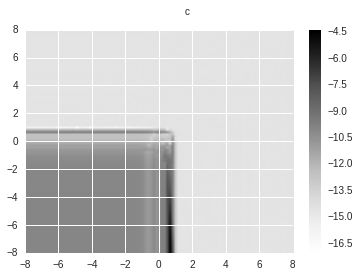

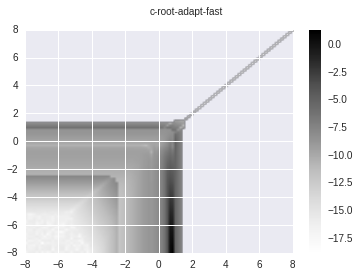

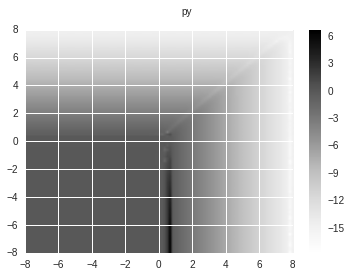

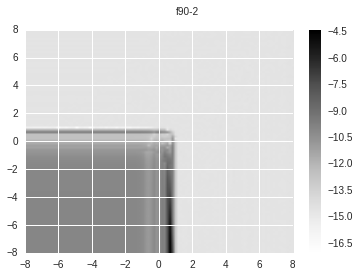

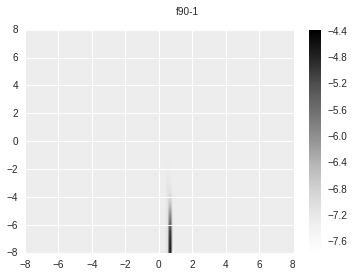

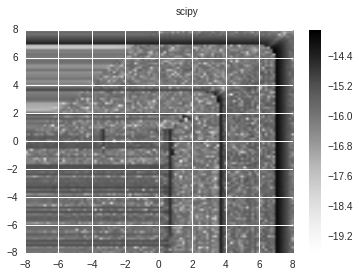

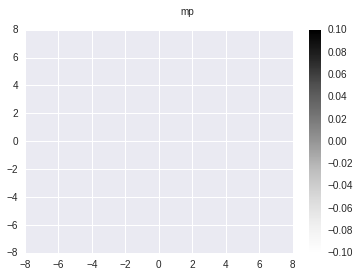

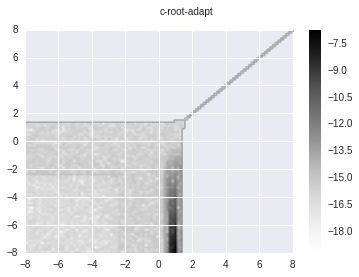

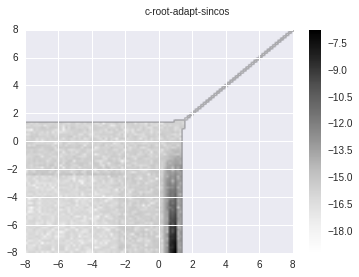

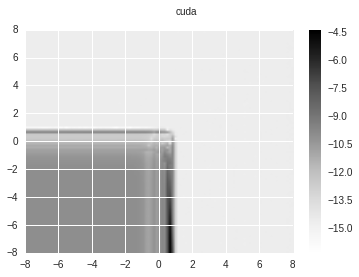

In [39]:
for implementation, function in wofz_impl.iteritems():
    wr, wi = function(x, y)
    plt.figure()
    plt.imshow(np.vectorize(mpmath.log10)(abs(wr - wr_ref)/wr_ref).astype(np.float64),
               origin="bottom",extent=[exp_min,exp_max,exp_min,exp_max],aspect='auto')
    plt.colorbar()
    plt.suptitle(implementation)

## III. Timing Benchmark

to be provided

In [40]:
def timeit(x,y, nrep=5):
    '''Time the implementation on the arrays x,y = x +iy'''
    timings = np.zeros(nrep)
    for implementation, function in wofz_impl.iteritems():
        #print implementation, function
        if implementation is not 'mpmath':
            for i in xrange(nrep):
                with Timer() as t:
                    wr, wi = function(x, y)
                timings[i] = t.interval_s
            print implementation, function, np.mean(timings) #timings
        
    

In [41]:
N = 1000
np.random.seed(0)
xx = np.random.normal(0.0, 4., N)
yy = np.random.normal(0.0, 4., N)
timeit(xx,yy, nrep=1)

c <numpy.lib.function_base.vectorize object at 0x7f6c78e778d0> 0.0350780487061
c-root-adapt-fast <numpy.lib.function_base.vectorize object at 0x7f6cbc1c1350> 0.0322849750519
py <numpy.lib.function_base.vectorize object at 0x7f6c78e6b9d0> 0.0601050853729
f90-2 <numpy.lib.function_base.vectorize object at 0x7f6c78e6b650> 0.00101685523987
f90-1 <numpy.lib.function_base.vectorize object at 0x7f6c78e6bb50> 0.000968933105469
scipy <function wofz at 0x7f6c78e6faa0> 0.000695943832397
mp <numpy.lib.function_base.vectorize object at 0x7f6c78e9b850> 2.61211395264
c-root-adapt <numpy.lib.function_base.vectorize object at 0x7f6cbc1be210> 0.0321989059448
c-root-adapt-sincos <numpy.lib.function_base.vectorize object at 0x7f6cbc1c13d0> 0.0319790840149
cuda <function wofz at 0x7f6cbc1b0c08> 0.00141501426697


In [25]:
N = 1
np.random.seed(0)
xx = np.random.normal(0.0, 4., N)
yy = np.random.normal(0.0, 4., N)
xx = np.ndarray(xx, dtype=np.float64)
yy = np.ndarray(yy, dtype=np.float64)
print type(xx)
timeit(xx,yy, nrep=100)

<type 'numpy.ndarray'>
c <numpy.lib.function_base.vectorize object at 0x7f9ca2154a90> 0.000307757854462
c-root-adapt-fast <numpy.lib.function_base.vectorize object at 0x7f9c97960cd0> 0.000310401916504
py <numpy.lib.function_base.vectorize object at 0x7f9c97958d50> 0.000238931179047
f90-2 <numpy.lib.function_base.vectorize object at 0x7f9c97958bd0> 5.71918487549e-05
f90-1 <numpy.lib.function_base.vectorize object at 0x7f9c97958c90> 5.7201385498e-05
scipy <function wofz at 0x7f9ca214b8c0> 1.75857543945e-05
mp <numpy.lib.function_base.vectorize object at 0x7f9ca44fc750> 0.00469938278198
c-root-adapt <function wofz_root at 0x7f9c97957938> 4.52303886414e-05
c-root-adapt-sincos <numpy.lib.function_base.vectorize object at 0x7f9c97960d90> 0.000307109355927
c-root-adapt-vec <numpy.lib.function_base.vectorize object at 0x7f9c97960c50> 0.000306322574615
cuda <function wofz at 0x7f9c97957b90> 0.00312368392944


/home/shegglin/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/shegglin/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [42]:
x = np.random.normal(0., 1., 100000)
y = np.random.normal(0., 1., 100000)

stats = %prun -r wofz_impl['c-root-adapt'](x,y)
